# Exploratory Data Analysis: Two Sigma Dataset

EDA base reference: 
- https://www.kaggle.com/poonaml/two-sigma-connect-rental-listing-inquiries/two-sigma-renthop-eda
- https://www.kaggle.com/neviadomski/two-sigma-connect-rental-listing-inquiries/data-exploration-two-sigma-renthop


In [2]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

from skimage import *
from matplotlib import pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
data_src = "../data/twosigma"

In [4]:
train_df = pd.read_json(os.path.join(data_src, "train.json"))

In [5]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [6]:
# any null values in the data
print train_df.isnull().any()

bathrooms          False
bedrooms           False
building_id        False
created            False
description        False
display_address    False
features           False
interest_level     False
latitude           False
listing_id         False
longitude          False
manager_id         False
photos             False
price              False
street_address     False
dtype: bool


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [5]:
# convert to dateime; Useful to separate day / month / year.. 
train_df.created = pd.to_datetime(train_df.created)

## Listing features

- Clean up listing-features: Remove special chars, stop words

More thoughts:
- Can we extract some special features such as
    Are cats allowed? Are dogs allowed? Is laundry available? Elevator available? etc.. 
  Using bag of words is the lame way of doing.. can we extract specificlly? 

In [62]:
# cleanup listing features
from nltk.corpus import stopwords

ignore_words = stopwords.words("english")
escape_chars = r"[-!:*;/.&<>^()#@$_+=,]"

def clean_features(v):
    new_v = []
    for each in v:
        cleaned_each = re.sub(escape_chars, " ", each.lower()).split()
        cleaned_each = " ".join([i for i in cleaned_each if i not in ignore_words])
        new_v.append(cleaned_each)
    return new_v
    
train_df["features_cleaned"] = train_df.features.apply(clean_features)

In [34]:
# word cloud of features
from wordcloud import WordCloud

all_features = []
for f in train_df.features_cleaned:
    all_features.extend([i.strip() for i in f])
features_text = " ".join(all_features)

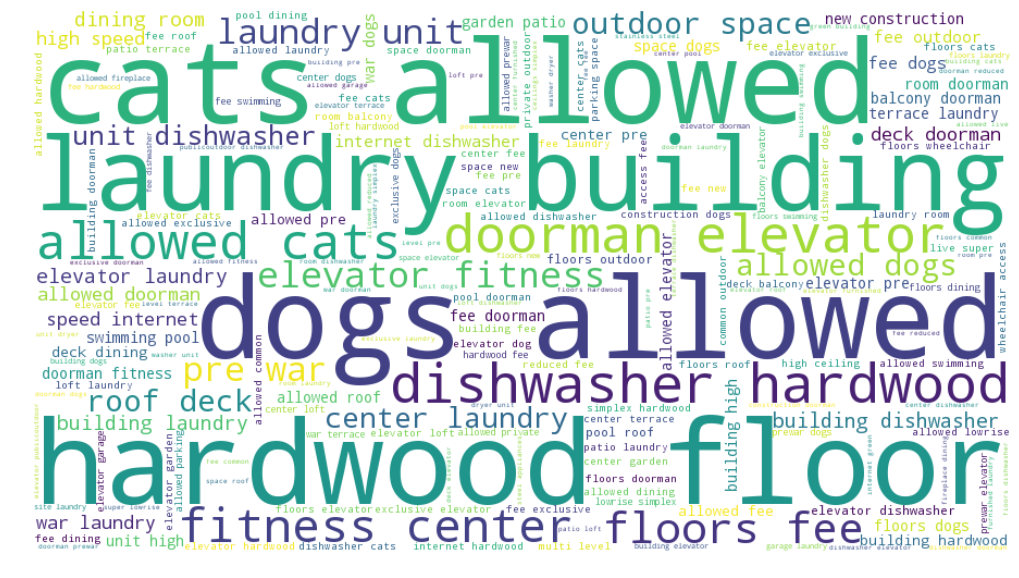

In [36]:
cloud = WordCloud(background_color="white", width=900, height=500)
cloud.generate(features_text)

plt.figure(figsize=(18,10))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.grid("off")
plt.show()

## Listing description

- Need to identify a meaningful way to represent the "quality" of description
    - Are sentences well structured? (readable / new lines / no spelling mistakes)
    - Number of sentences vs. Number of new lines; Number of spelling mistakes; Used bullet points?

In [10]:
train_df.description.head(20)

10        A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...
10000                                                      
100004    Top Top West Village location, beautiful Pre-w...
100007    Building Amenities - Garage - Garden - fitness...
100013    Beautifully renovated 3 bedroom flex 4 bedroom...
100014                                                     
100016    Stunning unit with a great location and lots o...
100020    This huge sunny ,plenty of lights 1 bed/2 bath...
100026                             <p><a  website_redacted 
100027    This is a spacious four bedroom with every bed...
100030    New to the market! Spacious studio located in ...
10004     Check out this one bedroom apartment in a grea...
100044    ***LOW FEE. Beautiful CHERRY OAK WOODEN FLOORS...
100048    Lincoln Square's premier full service building...
10005     Spacious 1-Bedroom to fit King-sized bed comfo...
100051    Stunning  full renovated studio unit. High cei...
100052    East Village is a great commun

In [7]:
# cleanup listing descriotion
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

ignore_words = stopwords.words("english")
escape_chars = r"[-!:*;/.&<>^()#@$_+=,]"

def clean_description(v):
    soup = BeautifulSoup(v, "html.parser")
    words = re.sub(escape_chars, " ", soup.get_text().lower()).split()
    new_v = " ".join([i for i in words if i not in ignore_words])
    return new_v
    
train_df.description_cleaned = train_df.description.apply(clean_description)

/usa/suryak/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:219: UserWarning:

"." looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.



In [26]:
train_df.description_cleaned.head(20)

10        brand new 3 bedroom 1 5 bath apartmentenjoy fo...
10000                                                   NaN
100004    top top west village location beautiful pre wa...
100007    building amenities garage garden fitness room ...
100013    beautifully renovated 3 bedroom flex 4 bedroom...
100014                                                  NaN
100016    stunning unit great location lots natural ligh...
100020    huge sunny plenty lights 1 bed 2 bath offers b...
100026                                                  NaN
100027    spacious four bedroom every bedroom able fit q...
100030    new market spacious studio located 80s well ma...
10004     check one bedroom apartment great location was...
100044    low fee beautiful cherry oak wooden floorsthe ...
100048    lincoln square's premier full service building...
10005     spacious 1 bedroom fit king sized bed comforta...
100051    stunning full renovated studio unit high ceili...
100052    east village great community g

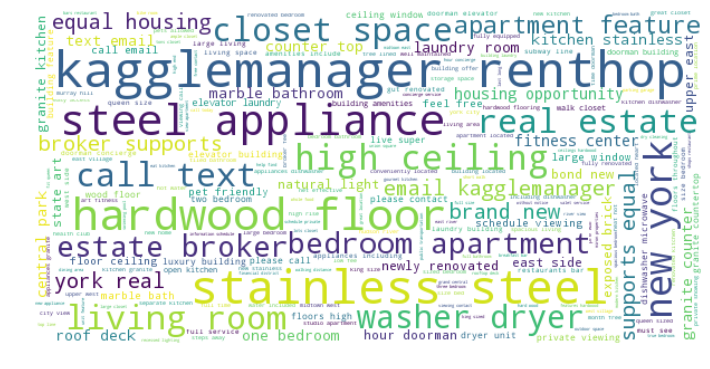

In [12]:
all_description = " ".join(train_df.description_cleaned.dropna())

from wordcloud import WordCloud

cloud = WordCloud(background_color="white", width=600, height=300)
cloud.generate(all_description)

plt.figure(figsize=(12,8))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.grid("off")
plt.show()

## Date created

In [8]:
train_df["created_month"] = train_df.created.dt.month

## Photos count

While its interesting to analyze images, 80GB is pretty heavy for now.

In [9]:
# images count
train_df["photos_count"] = train_df.photos.apply(len)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2352254f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f23521fdd50>]], dtype=object)

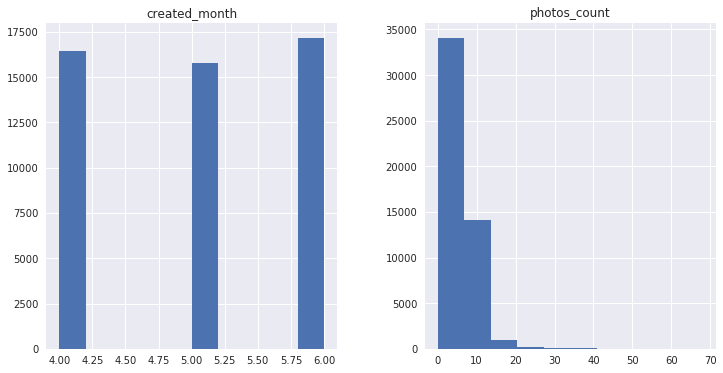

In [98]:
train_df[ ["created_month", "photos_count"] ].hist(figsize=(12,6))

In [10]:
# convert labels to integers.. for classification
manager_labels, manager_uniques = pd.factorize(train_df.manager_id)
train_df["manager_id_label"] = manager_labels

addr_labels, add_uniques = pd.factorize(train_df.display_address)
train_df["display_address_label"] = addr_labels

interest_labels, interest_uniques = pd.factorize(train_df.interest_level)
train_df["interest_level_label"] = interest_labels

In [17]:
# just to recollect..
train_df.columns.values

array([u'bathrooms', u'bedrooms', u'building_id', u'created',
       u'description', u'display_address', u'features', u'interest_level',
       u'latitude', u'listing_id', u'longitude', u'manager_id', u'photos',
       u'price', u'street_address', 'created_month', 'created_year',
       'created_quarter', 'photos_count', 'manager_id_label',
       'display_address_label'], dtype=object)

## Group latitude and longitudes..

In [98]:
# Group lat and lng into groups

from sklearn.cluster import KMeans
lat_lng = train_df[["latitude", "longitude"]].values
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(lat_lng)
train_df["lat_lng_region"] = kmeans.labels_

print train_df.lat_lng_region.unique()

[4 0 9 7 6 1 5 8 2 3]


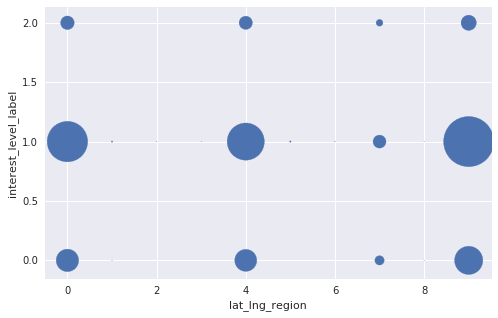

In [99]:
f1 = ["lat_lng_region", "interest_level_label"]
d1 = train_df.groupby(f1).count().reset_index()[ f1 + ["listing_id"] ]
d1.plot.scatter(x="lat_lng_region", y="interest_level_label", s=d1.listing_id / 6.0, figsize=(8, 5))

In [100]:
d1

,lat_lng_region,interest_level_label,listing_id
0,0,0,3026
1,0,1,9838
2,0,2,1109
3,1,0,1
4,1,1,11
5,2,1,1
6,3,1,1
7,4,0,2904
8,4,1,8292
9,4,2,1057


## Price..

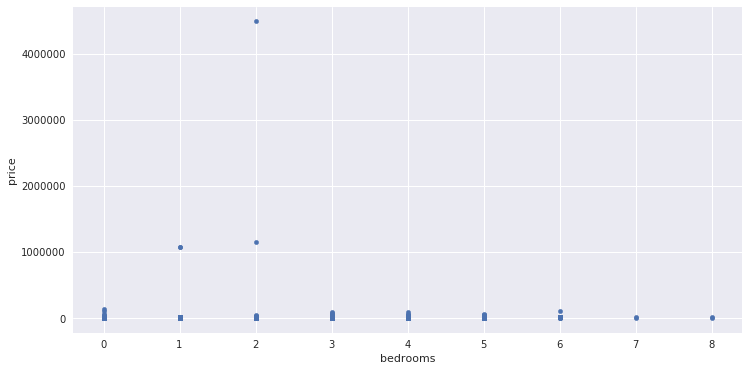

In [114]:
# Need to ignore these extreme values..
train_df.plot.scatter(x="bedrooms", y="price", figsize=(12,6))

In [134]:
train_df = train_df[~(train_df.price > 10**5)]

count    4.935200e+04
mean     1.050111e+03
std      5.739014e+03
min      2.150000e+01
25%      7.571071e+02
50%      9.250000e+02
75%      1.183333e+03
max      1.122500e+06
Name: price_per_room, dtype: float64


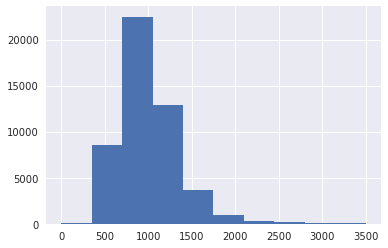

In [29]:
train_df["price_per_room"] = train_df.price / (train_df.bedrooms + train_df.bathrooms + 1)
print train_df.price_per_room.describe()
train_df.price_per_room.hist(range=(0, 3500))

(0, 100000)

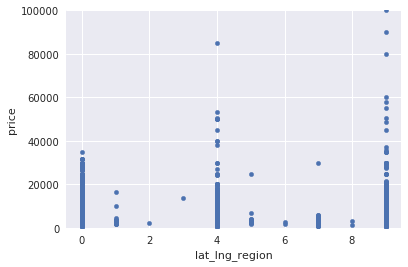

In [105]:
ax = train_df.plot.scatter(x="lat_lng_region", y="price")
ax.set_ylim(0, 100000)

## listing ID

/usa/suryak/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans



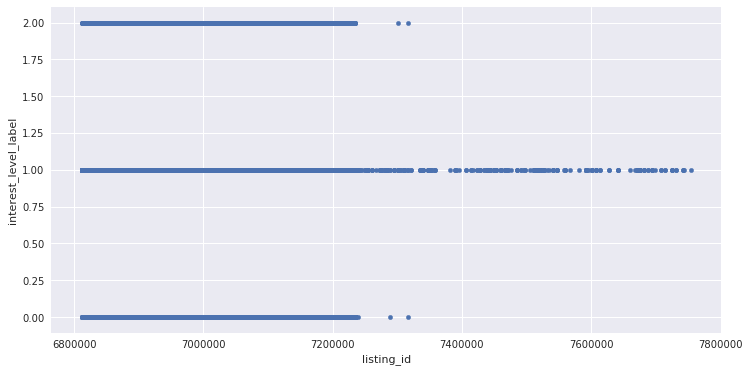

In [12]:
train_df.plot.scatter(x="listing_id", y="interest_level_label", figsize=(12,6))

## Display address

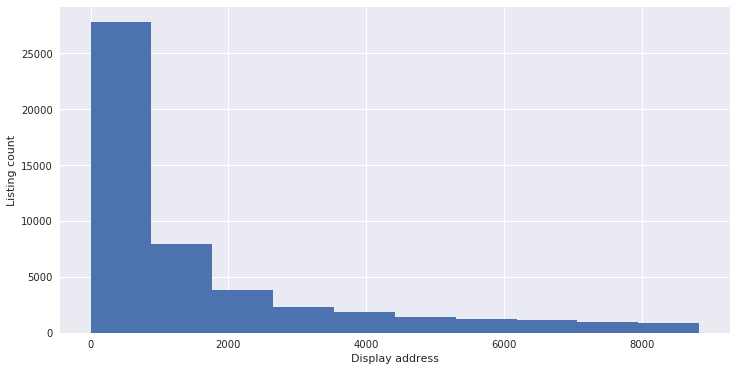

In [27]:
ax = train_df.display_address_label.hist(figsize=(12,6))
ax.set_xlabel("Display address")
ax.set_ylabel("Listing count")

## Extracting features (trailored)

In [84]:
def set_tailored_features(df):
    keywords = [
        ("dog", "allowed"), ("cat", "allowed"), ("fitness",), ("laundry",), ("dishwasher",),
        ("hardwood",), ("elevator",), ("doorman",), ("outdoor", "space"), ("new", "construction"),
        ("internet",), ("high", "ceiling"), ("swimming", "pool"), ("terrace",), ("balcony",),
        ("pet", "allowed"), ("lowrise",),
    ]
    
    def activate(row, kw):
        exists = 0
        for each in row.features_cleaned:
            if min([each.find(w) for w in kw]) >= 0:
                exists = 1
                break
        return exists        
                    
    for kw in keywords:
        col = "_".join(kw)
        df[col] = 0
        df[col] = df.apply(activate, args=(kw,), axis=1)
    
    return df

In [85]:
d = set_tailored_features(train_df)

In [87]:
print d.dog_allowed.sum()

22035

In [108]:
import datetime
today = datetime.datetime.now()

train_df["days_count"] = train_df.created.apply(lambda d: (today - d).days)
train_df.days_count

10        299
10000     311
100004    367
100007    366
100013    356
100014    365
100016    357
100020    371
100026    364
100027    382
100030    370
10004     320
100044    365
100048    375
10005     322
100051    366
100052    362
100053    365
100055    364
100058    375
100062    372
100063    377
100065    371
100066    367
10007     316
100071    357
100075    359
100076    362
100079    363
100081    358
         ... 
99915     359
99917     358
99919     376
99921     355
99923     379
99924     360
99931     359
99933     381
99935     365
99937     370
9994      317
99953     358
99956     368
99960     379
99961     362
99964     355
99965     381
99966     369
99979     370
99980     357
99982     377
99984     382
99986     370
99987     373
99988     362
9999      321
99991     379
99992     368
99993     376
99994     372
Name: days_count, dtype: int64